In [1]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import os
from glob import glob
import matplotlib.pyplot as plt

%matplotlib inline

#import talib as ta # conda activate cryt310
from matplotlib.ticker import AutoMinorLocator
import time
from itertools import zip_longest
from IPython.display import Javascript
import datetime
import schedule
import json,requests 

%load_ext autoreload
%autoreload 2

tickerpair="ETCUSDT" #GBPUSDT #LTCUSDT #ETHUSDT #BTCUSDT
#tickerpair="BNBUSDT" #BNBUSDT #AUDUSDT #XMRUSDT
intervals=['1m','3m','5m','15m','30m','1h','2h','3h','4h','6h','8h','12h','1d','3d','1w','1Month']

# define constants
tickerpair="ETCUSDT"
interval="1m"
from aver6_funcs import get_data
import pickle,tqdm
import random

In [5]:
# Set the style for the plots
plt.style.use('seaborn-v0_8-darkgrid')

# Customize the color cycle and other plot parameters
params = {
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'font.size': 14,
    'lines.linewidth': 2,
    'lines.markersize': 8,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.prop_cycle': plt.cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']),
    'legend.fontsize': 12
}
plt.rcParams.update(params)

In [6]:
with open("2_1_0_subset_symbols.pkl","rb") as f:
    subset_symbols = pickle.load(f)

In [7]:
subset_symbols[50]

'AGIX'

In [8]:
from concurrent.futures import ThreadPoolExecutor
import concurrent
import tqdm

def worker(ss, ii):
    try:
        tickerpair = ss + "USDT"
        if "USD" in ss:
            return None
        dfmpl = get_data(tickerpair, interval, limit=95000, type="data")
        print(ss,end=" ")
        return (dfmpl.copy(), tickerpair, ii)
    except ValueError:
        return None

In [9]:
%%time 
dfmpl_list = []

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {executor.submit(worker, ss, ii): (ss, ii) for ii, ss in enumerate(subset_symbols[:])}
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result:
            dfmpl_list.append(result)

XLM XRP ETH BTC SOL ARB DOGE LINK BNB OP ADA MATIC SNX LTC BCH HBAR DAR EUR 1INCH AVAX DYDX USTC MKR SHIB COMP LDO INJ FTM DOT GALA ACA LQTY NEAR APE MASK TRX XEC APT UNI RNDR FIL ATOM CFX AGIX LUNC AGLD LUNA AAVE EOS XMR ALGO FET GMT SAND ETC RDNT MANA TOMO WAVES AXS MAGIC FLOW XTZ STX ACH LINA CRV CELO BAND ONE VET ROSE CAKE EDU ID ICP OCEAN ARPA ANKR SUSHI RUNE GRT DASH GAL ASTR CHZ MINA FXS EGLD PAXG DUSK AR HIGH QNT KAVA STMX STG SSV ZEN IMX IOTX NEO THETA ZIL JASMY MC XVS SXP MOB ENJ ZEC MDT LPT AUDIO LRC GMX SKL TWT ENS HOOK CKB API3 WOO GBP KLAY VOXEL LIT BNX RSR UNFI JOE VGX UMA LOKA POLYX BEL ADX FIDA SYN KSM IOTA HFT T C98 PHB BAT RAD OMG ALICE REEF ICX VIDT QTUM ONT IOST KEY CHR HOT XEM YFI RPL AMB TRU PEOPLE KDA PYR ALPHA CTSI GLMR REN RVN FLUX BSW BLZ YGG LEVER BAKE BURGER TLM OG IDEX SLP BETH COTI DENT OGN DODO CTK ATA GTC LOOM BETA GNS POND CELR VIB KNC PLA CLV OSMO GHST AMP CITY ALPINE SANTOS CHESS BOND SPELL ILV RIF SFP TVK PORTO RARE BICO BTTC WAXP KMD PHA OAX MBL QI

In [9]:
%%time
#with open("2_1_0_analysisdata/2_1_0dfmpl_list.pkl","wb")as f:
#    pickle.dump(dfmpl_list,f)
with open("2_1_0_analysisdata/2_1_0dfmpl_list.pkl","rb")as f:
    dfmpl_list = pickle.load(f)

CPU times: total: 359 ms
Wall time: 2.19 s


In [10]:
dfmpl,_,_ = dfmpl_list[0]

In [11]:
v = ((dfmpl.Close-dfmpl.Open)/dfmpl.Open).values

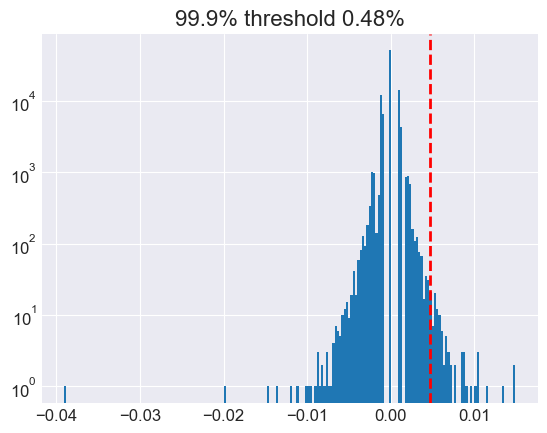

In [12]:
percentile_threshold = np.percentile(v,99.9)
plt.hist(v,bins=200);
plt.axvline(percentile_threshold,ls="--",c="r")
plt.title(f"99.9% threshold {percentile_threshold:.2%}")
plt.yscale("log")

# back testing results

In [13]:
%%time
threshold=-0.006
dfmpl,tickerpair,indd = dfmpl_list[0]
collated_data_list = []
all_locs = []
for dfmpl,tickerpair,_ in dfmpl_list:
    vals = ((dfmpl.Close-dfmpl.Open)/dfmpl.Open).values
    a1=np.where(vals<threshold)[0]
    a2=np.diff(a1)
    a3=np.where(a2==1)
    def validate_df(loc):
        df_ = dfmpl.iloc[loc:loc+2]
        v0,v1 = (df_.Open*df_.Volume).values
        if v0>3e6 and v1>3e6:
            return True
        return False
    if len(a3)>0:
        locs=a1[a3]
        if len(locs)>0:
            collated_data = np.asarray([vals[loc:loc+5] for loc in locs if validate_df(loc)])
            if len(collated_data)>0:
                print(tickerpair,len(collated_data),[loc for loc in locs if validate_df(loc)])
                [all_locs.append(loc)for loc in locs if validate_df(loc)]
                collated_data_list.append(collated_data)
    #len(locs)
collated_data = np.vstack(collated_data_list)
profits = collated_data[:,2]
collated_data.shape

XRPUSDT 5 [47811, 51790, 77812, 77823, 81348]
ETHUSDT 4 [9897, 38281, 88686, 94784]
BTCUSDT 4 [38319, 77933, 88724, 94822]
SOLUSDT 2 [77793, 77804]
ARBUSDT 10 [30, 41, 42, 43, 75, 317, 1491, 33323, 38390, 44578]
DOGEUSDT 8 [55191, 55199, 55202, 55244, 55321, 59674, 77648, 79403]
EDUUSDT 2 [101, 102]
IDUSDT 1 [2]
CPU times: total: 2.47 s
Wall time: 3.29 s


(36, 5)

Text(0, 0.5, 'counts')

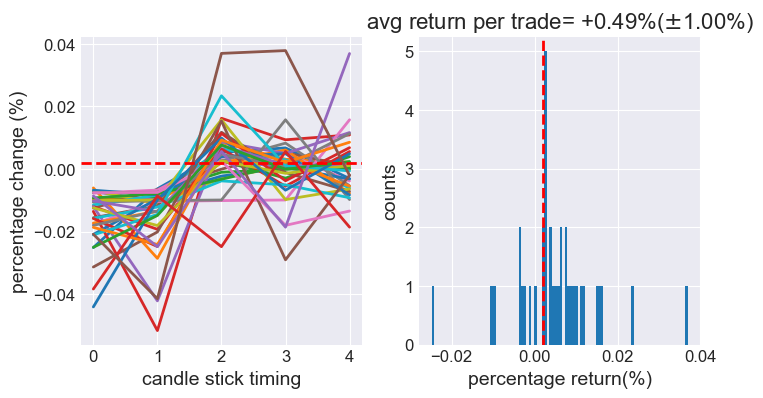

In [14]:
fig,axx=plt.subplots(1,2,figsize=(8,4))
ax=axx[0]
ax.plot(collated_data.T)
ax.axhline(0.002,ls="--",c="r")
ax.set_xlabel("candle stick timing")
ax.set_ylabel("percentage change (%)")
ax=axx[1]
ax.hist(collated_data[:,2],bins=100);
ax.axvline(0.002,ls="--",c="r")
ax.set_title(f"avg return per trade= {np.mean(collated_data[:,2]):+.2%}($\pm${np.std(collated_data[:,2]):.2%})")
ax.set_xlabel("percentage return(%)")
ax.set_ylabel("counts")

cumulative profits with zero fees=+19.10%
cumulative profits with 0.3% fees=+6.95%
number of trading days 65.97222222222221


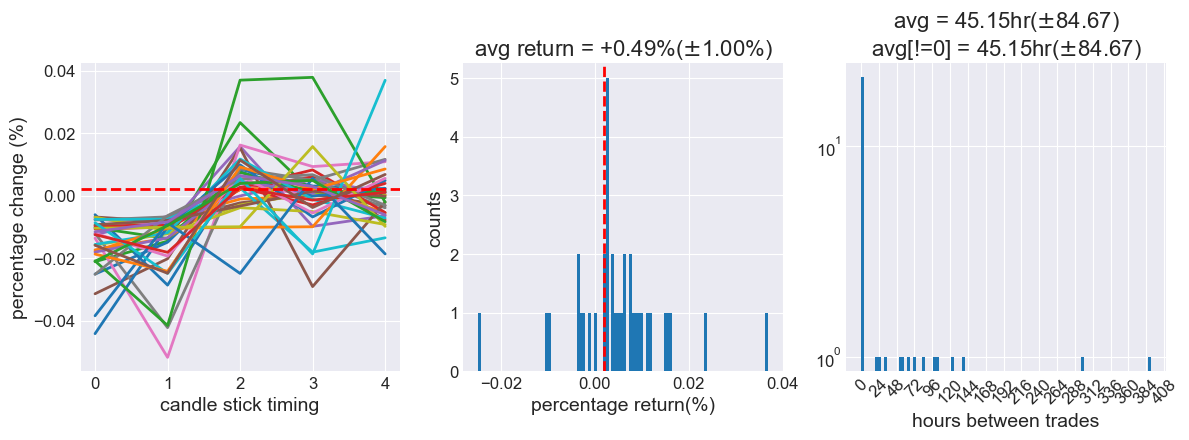

In [15]:
fig,axx=plt.subplots(1,3,figsize=(14,4),dpi=100)
ax=axx[0]
ax.plot(collated_data.T[:,random.sample(range(collated_data.shape[0]),min(200,collated_data.shape[0]))])
ax.axhline(0.002,ls="--",c="r")
ax.set_xlabel("candle stick timing")
ax.set_ylabel("percentage change (%)")
ax=axx[1]
ax.hist(collated_data[:,2],bins=100);
ax.axvline(0.002,ls="--",c="r")
strr = f"avg return = {np.mean(collated_data[:,2]):+.2%}($\pm${np.std(collated_data[:,2]):.2%})"
ax.set_title(strr)
ax.set_xlabel("percentage return(%)")
ax.set_ylabel("counts")
ax=axx[2]
hours_between_trades=np.diff(sorted(all_locs))/60
ax.hist(hours_between_trades,bins=100);
strr= f"avg = {np.mean(hours_between_trades):.2f}hr($\pm${np.std(hours_between_trades):.2f})"
strr+=f"\navg[!=0] = {np.mean(hours_between_trades[hours_between_trades!=0]):.2f}hr($\pm${np.std(hours_between_trades[hours_between_trades!=0]):.2f})"
ax.set_title(strr)
ax.set_yscale("log")
ax.set_xlabel("hours between trades")
ax.set_xticks(np.arange(0,max(hours_between_trades)+24,24))
ax.set_xticklabels([f"{n:.0f}" for n in np.arange(0,max(hours_between_trades)+24,24)],rotation=45);
print(f"cumulative profits with zero fees={np.product(collated_data[:,2]+1)-1:+.2%}")
print(f"cumulative profits with 0.3% fees={np.product(collated_data[:,2]+1-0.003)-1:+.2%}")
print("number of trading days",95000/60/24)

## visualising backtest results

In [49]:
import csv
snp500 = []
snp_day = []
with open('Downloaded_snp500.csv', newline='') as f:
    reader = csv.reader(f)
    for i,row in enumerate(reader):
        #print(row[4])
        if i!=0:
            snp500.append(float(row[4].replace(",","")))
            snp_day.append(row[0])
snp500 = snp500[::-1]
snp_day = snp_day[::-1]
snp_days = [datetime(*[int(ii) for ii in [snp_dayi.split("/")[iii] for iii in [2,0,1]]]) for snp_dayi in snp_day]

In [65]:
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 11, 30)
mean_trades=np.mean(hours_between_trades)/24
delta = timedelta(days=mean_trades)
dates = [start_date + i*delta for i in range((end_date - start_date).days )]

In [66]:
int(365*24/np.mean(hours_between_trades))

194

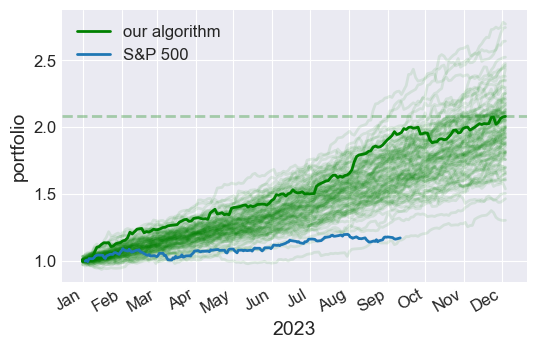

In [77]:
random.seed(51)

plt.figure(figsize=(6,4))
for _ in range(100): # monte carlo selection from backtested results
    p1 = 1
    profit_array = [] 
    for _ in range(int(365*24/np.mean(hours_between_trades))-14):
        p=random.choice(profits)
        p1*=(p+1-0.001)
        profit_array.append(p1)
    plt.plot(dates[:len(profit_array)],profit_array,alpha=0.1,c="g")
    #plt.plot( np.arange(len(profit_array))*mean_trades,profit_array,alpha=0.1,c="g")
plt.plot(dates[:len(profit_array)],profit_array,alpha=1,c="g",label="our algorithm")
#plt.plot( np.arange(len(profit_array))*mean_trades,profit_array,alpha=1,c="g",label="our algorithm")
plt.axhline(profit_array[-1],ls="--",c="g",alpha=0.3)
#plt.plot(dates[:len(snp500)],np.asarray(snp500)/snp500[0],label="S&P 500")
plt.plot( snp_days,np.asarray(snp500)/snp500[0],label="S&P 500")
plt.legend()
plt.xlabel("2023")
plt.ylabel("portfolio")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Rotation of date labels

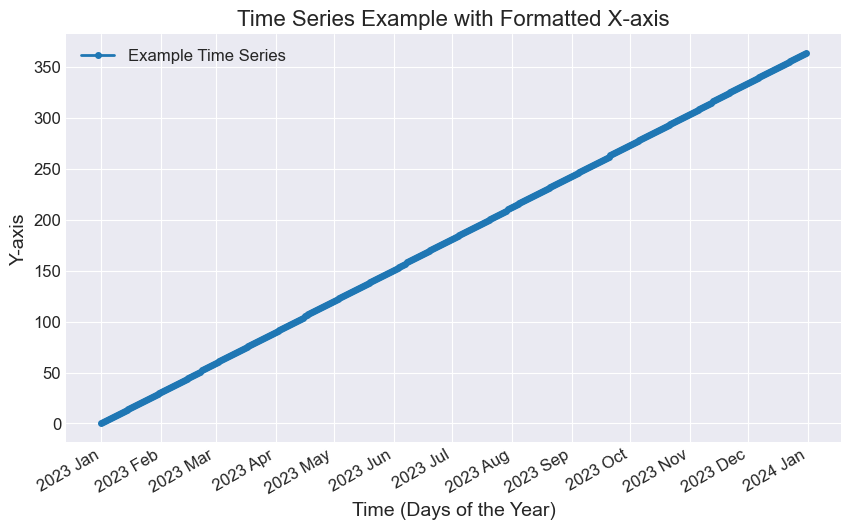

In [26]:
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Generate example data: from day 1 to day 365
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 31)
delta = timedelta(days=1)
dates = [start_date + i*delta for i in range((end_date - start_date).days + 1)]
y_values = [i for i in range(len(dates))]

# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(dates, y_values, label="Example Time Series", marker='o', markersize=4)

# Configure the x-axis to display time
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Rotation of date labels

plt.xlabel("Time (Days of the Year)")
plt.ylabel("Y-axis")
plt.title("Time Series Example with Formatted X-axis")
plt.legend()

plt.show()